In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# dataset = DatasetHARUML20(mode = 'leave-one-subject')
dataset = DatasetPAMAP2(mode = 'leave-one-subject',signals=['heartrate'])
# CLASS_LABELS = [
#     "Sedentary",
#     "Light",
#     "Moderate",
#     "Vigorous",
# ]
saver = MetricsSaver('PAMAP2_heartrate_HAR', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy'])

In [3]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    # if datasetName == 'PAMAP2':
    le = LabelEncoder()
    dataset.y_train = le.fit_transform(dataset.y_train)
    dataset.y_test = le.transform(dataset.y_test)
    
    # Preparing data
    ts_train = TSerie(dataset.X_train, dataset.y_train)
    ts_test = TSerie(dataset.X_test, dataset.y_test)
    # ts_train.center()
    # ts_test.center()
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    
    # Getting features
    model = UMAP_FL(n_components=16,n_neighbors=15, n_epochs=1000)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    # break
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_tr

In [6]:
# # if datasetName == 'PAMAP2':
classes = np.unique(real_classes).astype(int)
CLASS_LABELS = [dataset.activities_map[classL] for classL in le.inverse_transform(classes) ]

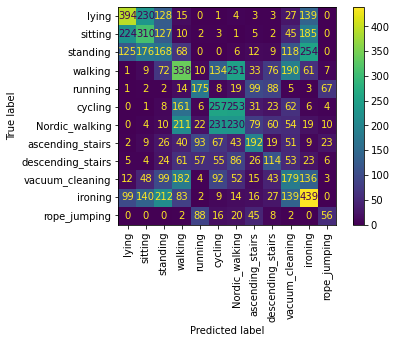

In [7]:

saveConfusionMatrix(real_classes, predicted_classes,'PAMAP_heartrate_HAR', labels=CLASS_LABELS, xrotation=90)

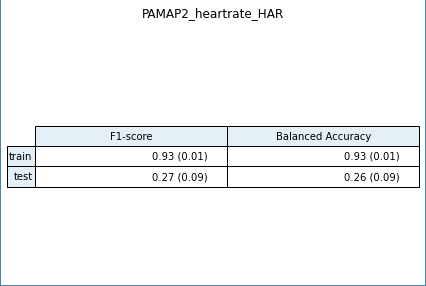

In [8]:
saver.toImage()